## Team members 
1. Sai Hruthik Gangapuram 
2. Sujith Kumar Gajarla

# Task 1: Importing packages

In [1]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=71b7d9de45ff4ae4a57b526ac58c3a18ddcac2536369b2f288a23c51d8690e39
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=c5ba9a9db00889c87ca1a4e4e6957055f16f4ce722b7c83add8a194ced2a6f68
  Stored in directory: /root/.cache/pip/w

In [3]:
import sys
import cv2
import torch
import torchvision
import numpy as np 
import pandas as pd
from torch import nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 2: Setup Configurations

In [19]:
sys.path.append('/content/drive/MyDrive/dp/')
DEVICE = 'cuda'
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 320
BATCH_SIZE = 8
ENCODER = 'efficientnet-b7'
WEIGHTS = 'imagenet'

In [5]:
data_frame = pd.read_csv('/content/drive/MyDrive/dp/train.csv')
data_frame.tail(5)

,masks,images
138,white masked images\95.png,training samples\95.jpg
139,white masked images\96.png,training samples\96.jpg
140,white masked images\97.png,training samples\97.jpg
141,white masked images\98.png,training samples\98.jpg
142,white masked images\99.png,training samples\99.jpg


In [6]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   masks   143 non-null    object
 1   images  143 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


# Task 3: Defining visulization functions

In [7]:
def mask_to_rgb(mask, label=False):
    color_map={
        0: (0, 0, 0), # Background
        1: (255, 0, 0), # Class 1
        2: (0, 255, 0), # Class 2
        3: (0, 0, 255), # Class 3
        4: (0, 128, 128), # Class 4
        5: (128, 0, 128), # Class 5
    }
    color_to_class = {
      (255, 0, 0): "Horse",  # Red pixel represents Horse
      (0, 255, 0): "Bench",  # Green pixel represents Bench
      (0, 0, 255): "Water Dispenser",  # Blue pixel represents Water dispenser
      (0, 128, 128): "Trash bin",  # Blue pixel represents Dust bin
      (128, 0, 128): "Stop Sign",  # Blue pixel represents stop sign
    }
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()
    
    # Count the number of occurrences of each RGB color in the predicted mask.
    counts = {}
    for row in range(320):
        for column in range(320):
            class_index = mask[0][row][column]
            if class_index != 0:
                rgb = color_map[class_index]
                if rgb in counts:
                    counts[rgb] += 1
                else:
                    counts[rgb] = 1
                    
    # Determine the RGB color with the highest count that is not the background color.
    max_count = 0
    max_rgb = None
    for rgb, count in counts.items():
        if count > max_count and rgb != (0,0,0):
            max_count = count
            max_rgb = rgb
    
    # Replace all non-background class indexes in the mask with the chosen RGB color.
    if max_rgb is not None:
        rgb_mask = np.zeros((320, 320, 3), dtype=np.uint8)
        for row in range(320):
            for column in range(320):
                class_index = mask[0][row][column]
                if class_index != 0:
                    rgb = color_map[class_index]
                    if rgb == max_rgb:
                        rgb_mask[row][column] = rgb
                    else:
                        rgb_mask[row][column] = max_rgb
                else:
                    rgb_mask[row][column] = (0,0,0)
    else:
        # If all non-background colors have zero occurrences, use the original function.
        rgb_mask = np.zeros((320, 320, 3), dtype=np.uint8)
        for row in range(320):
            for column in range(320):
                class_index = mask[0][row][column]
                rgb_mask[row][column] = color_map[class_index]
  
    if label:
      return rgb_mask, color_to_class.get(max_rgb)    
    return rgb_mask


def show_image(image, mask, pred_image=None):
    image = image.permute(1, 2, 0).squeeze().numpy()
    mask = mask_to_rgb(mask)

    if pred_image is not None:
        pred_image = mask_to_rgb(pred_image)

    image = image / np.max(image)
    mask = mask / np.max(mask)
    
    if pred_image is not None:
        pred_image = pred_image / np.max(pred_image)

    if pred_image is None:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.set_title('IMAGE')
        ax1.imshow(image, cmap='gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask)

    else:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

        ax1.set_title('IMAGE')
        ax1.imshow(image, cmap='gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask)

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image)

    plt.show()

        
def classIndexMask(mask):
    # Define a dictionary mapping RGB color values to class indices
    color_to_class = {
      (0, 0, 0): 0,  # Black pixel represents background
      (255, 0, 0): 1,  # Red pixel represents Horse
      (0, 255, 0): 2,  # Green pixel represents Bench
      (0, 0, 255): 3,  # Blue pixel represents Water dispenser
      (0, 128, 128): 4,  # light blue pixel represents Dust bin
      (128, 0, 128): 5,  # pink pixel represents stop sign
    }

    # Load a masked image in RGB format
    mask_image = Image.open(mask)
    mask_image = mask_image.resize((320, 320))

    # Convert the RGB image to a numpy array
    mask_array = np.array(mask_image)

    # Create a new numpy array to hold the class index mask
    class_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)

    # Iterate over each RGB color value and map it to a class index
    for color, class_idx in color_to_class.items():
      # Find the indices in the numpy array where the RGB color value matches the dictionary key
      color_indices = np.where(np.all(mask_array == color, axis=-1))
      # Assign the corresponding class index to the pixels at those indices
      class_indices[color_indices] = class_idx
    return class_indices

Image Size (320, 320, 3)
Mask Size (320, 320, 3)


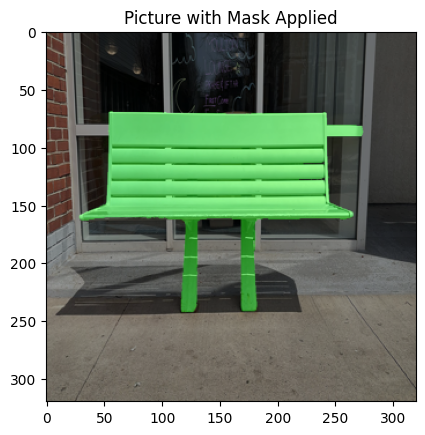

In [8]:
row = data_frame.iloc[39]
dir = "/content/drive/MyDrive/dp/"
image_path = dir+row.images.replace('\\', '/')
mask_path = dir+row.masks.replace('\\', '/')
img = Image.open(image_path)
mask = Image.open(mask_path)
mask_np = np.array(mask)
mask_np_gray = cv2.cvtColor(mask_np, cv2.COLOR_RGB2GRAY).copy()

new_size = (320, 320)
img = img.resize(new_size)
mask = mask.resize(new_size)

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)
plt.imshow(img)
plt.imshow(mask, alpha=0.4)
plt.title('Picture with Mask Applied')
plt.show()

# Task 4: Spliting the dataset into training | testing| validation

In [9]:
training_data, testing_data = train_test_split(data_frame, test_size=0.2, random_state=42)

validation_data, test_data = train_test_split(testing_data, test_size=0.5, random_state=42)

# Task 5 : Create Custom Dataset 

In [10]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df):
        
        self.df=df
        self.transforms = transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self ,idx):
        row = self.df.iloc[idx]
        image_path = row['images']
        mask_path = row['masks']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = classIndexMask(mask_path)
        mask =np.expand_dims(mask ,axis=-1)#(h,w,1)
        #(h,w,c) -> (c,h,w)
        image = np.transpose(image ,(2,0,1)).astype(np.float32)
        mask = np.transpose(mask ,(2,0,1)).astype(np.float32)
        original_image = self.transforms(torch.Tensor(image))
        original_image = original_image/255.0 # normalizing original image tensor [0,1] range
        return original_image, torch.Tensor(mask)

In [11]:
train_data_set = SegmentationDataset(training_data)
valid_data_set = SegmentationDataset(validation_data)
test_data_set = SegmentationDataset(test_data)

In [12]:
print('Size of Training dataset: {}'.format(train_data_set.__len__()))
print('Size of Testing dataset: {}'.format(test_data_set.__len__()))
print('Size of Validation dataset: {}'.format(valid_data_set.__len__()))

Size of Training dataset: 114
Size of Testing dataset: 15
Size of Validation dataset: 14


# Task 6: Loading dataset into Batches

In [13]:
train_loader = DataLoader(train_data_set, batch_size=8, shuffle=True)

val_loader = DataLoader(valid_data_set, batch_size=8, shuffle=True)

test_loader = DataLoader(test_data_set, batch_size=8, shuffle=True)

In [14]:
print('Total number of batches in train data loader: {}'.format(len(train_loader)))
print('Total number of batches in test data loader: {}'.format(len(test_loader)))
print('Total number of batches in validation data loader: {}'.format(len(val_loader)))

Total number of batches in train data loader: 15
Total number of batches in test data loader: 2
Total number of batches in validation data loader: 2


# Task 7: Visualising 1st sample in each batch

In [15]:
for image , mask in train_loader:
    break
print (f'One batch image shape: {image.shape}')
print (f'One batch image shape: {mask.shape}')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


One batch image shape: torch.Size([8, 3, 320, 320])
One batch image shape: torch.Size([8, 1, 320, 320])


### Train data loader

In [16]:
# for batch_idx, (Original_images, Masked_images) in enumerate(train_loader):
#     original_image = Original_images[0]
#     masked_image = Masked_images[0]
#     show_image(original_image, masked_image)

### Test data loader

In [17]:
# for batch_idx, (Original_images, Masked_images) in enumerate(test_loader):
#     original_image = Original_images[0]
#     masked_image = Masked_images[0]
#     show_image(original_image, masked_image)

### Validation data loader

In [18]:
# for batch_idx, (Original_images, Masked_images) in enumerate(val_loader):
#     original_image = Original_images[0]
#     masked_image = Masked_images[0]
#     show_image(original_image, masked_image)

# Task 8 : Loading Pre-Trained Segmentation Model

In [19]:
class SegmentationModel (nn.Module):
    def __init__(self):
        super (SegmentationModel , self).__init__()

        self.arc = smp.Unet(
            encoder_name= ENCODER , # loading pre-trained model
            encoder_weights=  WEIGHTS , # loading pre-trained weights
            in_channels= 3 ,
            classes=  6, # (we have 6 classes including background)
            activation = 'softmax'
        )
        
        
    def forward(self, images, masks=None):
        logits = self.arc(images)

        if masks is not None:
            masks = masks.squeeze(1) # remove the channel dimension
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, masks)
            return logits, loss

        return logits

In [20]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:04<00:00, 61.4MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            64, 16, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            16, 64, kernel_size=(1, 1), stride=(1, 1)
            (static_padding):

# Task 9: Training and validation

In [21]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0
    tk0 = tqdm(data_loader, total=len(data_loader))
    for i, (images, masks) in enumerate(tk0):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        masks = masks.long()  # Convert to integer tensor
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.mean().backward()
        optimizer.step()
        total_loss += loss.item()
        tk0.set_postfix(loss=total_loss/(i+1))
    return total_loss / len(data_loader)

def eval_fn(data_loader, model):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        tk0 = tqdm(data_loader, total=len(data_loader))
        for i, (images, masks) in enumerate(tk0):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            masks = masks.long()  # Convert to integer tensor
            logits, loss = model(images, masks)
            total_loss += loss.item()
            tk0.set_postfix(loss=total_loss/(i+1))
    return total_loss / len(data_loader)


# Task 10: Defining an Optimizer

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
training_loss = dict()
validation_loss = dict()
best_valid_losses = dict()
for lr in learning_rates:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    best_valid_loss = 1000
    train_losses = list()
    valid_losses = list()
    for i in range(50):
        train_loss = train_fn(train_loader , model , optimizer)
        valid_loss = eval_fn(val_loader , model )
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
    if valid_loss< best_valid_loss :
        torch.save(model.state_dict(), '/content/drive/MyDrive/Deep learning project final/Model{}.pt'.format(lr))
        print ("SAVED")
        best_valid_loss = valid_loss
    print(f"Epoch : {i+1} train_loss :{train_loss} valid_loss :{valid_loss}")
    training_loss.update({lr:train_losses})
    validation_loss.update({lr:valid_losses})
    best_valid_losses.update({lr:best_valid_loss})

  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████

SAVED
Epoch : 1 train_loss :1.302371875445048 valid_loss :1.257140338420868


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 2 train_loss :1.3079575935999552 valid_loss :1.2601222395896912


100%|██████████| 2/2 [00:03<00:00,  1.53s/it, loss=1.26]


Epoch : 3 train_loss :1.3099419434865316 valid_loss :1.2593785524368286


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 4 train_loss :1.316203204790751 valid_loss :1.2607972621917725


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 5 train_loss :1.3150347471237183 valid_loss :1.2571693658828735


100%|██████████| 2/2 [00:03<00:00,  1.65s/it, loss=1.25]


SAVED
Epoch : 6 train_loss :1.3117485602696737 valid_loss :1.2520787715911865


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.26]


Epoch : 7 train_loss :1.3094871282577514 valid_loss :1.2555235624313354


100%|██████████| 2/2 [00:02<00:00,  1.31s/it, loss=1.26]


Epoch : 8 train_loss :1.3089968681335449 valid_loss :1.2567655444145203


100%|██████████| 2/2 [00:02<00:00,  1.26s/it, loss=1.25]


SAVED
Epoch : 9 train_loss :1.3052793502807618 valid_loss :1.2512149810791016


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


SAVED
Epoch : 10 train_loss :1.3046680450439454 valid_loss :1.2509042024612427


100%|██████████| 2/2 [00:03<00:00,  1.50s/it, loss=1.26]


Epoch : 11 train_loss :1.3106240431467693 valid_loss :1.259028434753418


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 12 train_loss :1.3158486922581991 valid_loss :1.257818341255188


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


Epoch : 13 train_loss :1.3072249174118042 valid_loss :1.2544644474983215


100%|██████████| 2/2 [00:03<00:00,  1.65s/it, loss=1.26]


Epoch : 14 train_loss :1.313019609451294 valid_loss :1.2557469606399536


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


SAVED
Epoch : 15 train_loss :1.308869449297587 valid_loss :1.2501800656318665


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


Epoch : 16 train_loss :1.3155506292978922 valid_loss :1.2544913291931152


100%|██████████| 2/2 [00:02<00:00,  1.45s/it, loss=1.26]


Epoch : 17 train_loss :1.3131045738855998 valid_loss :1.2564349174499512


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 18 train_loss :1.3147566636403403 valid_loss :1.2583502531051636


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


Epoch : 19 train_loss :1.3132295529047648 valid_loss :1.2533777952194214


100%|██████████| 2/2 [00:03<00:00,  1.68s/it, loss=1.26]


Epoch : 20 train_loss :1.313449255625407 valid_loss :1.2578954100608826


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.25]


Epoch : 21 train_loss :1.312601892153422 valid_loss :1.253629207611084


100%|██████████| 2/2 [00:02<00:00,  1.23s/it, loss=1.26]


Epoch : 22 train_loss :1.3200852870941162 valid_loss :1.259491503238678


100%|██████████| 2/2 [00:03<00:00,  1.54s/it, loss=1.27]


Epoch : 23 train_loss :1.3085176547368367 valid_loss :1.2662944793701172


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


Epoch : 24 train_loss :1.324986457824707 valid_loss :1.253314197063446


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


SAVED
Epoch : 25 train_loss :1.3116294542948406 valid_loss :1.2474709749221802


100%|██████████| 2/2 [00:02<00:00,  1.22s/it, loss=1.26]


Epoch : 26 train_loss :1.305912184715271 valid_loss :1.2616685032844543


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 27 train_loss :1.3125852902730306 valid_loss :1.2594689726829529


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 28 train_loss :1.306339645385742 valid_loss :1.2575764656066895


100%|██████████| 2/2 [00:02<00:00,  1.44s/it, loss=1.25]


Epoch : 29 train_loss :1.318723702430725 valid_loss :1.254193663597107


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 30 train_loss :1.3166011651357015 valid_loss :1.2591779828071594


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 31 train_loss :1.3087173541386923 valid_loss :1.2569084763526917


100%|██████████| 2/2 [00:02<00:00,  1.33s/it, loss=1.25]


Epoch : 32 train_loss :1.305949060122172 valid_loss :1.2549405694007874


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.25]


Epoch : 33 train_loss :1.327232042948405 valid_loss :1.2499131560325623


100%|██████████| 2/2 [00:02<00:00,  1.23s/it, loss=1.26]


Epoch : 34 train_loss :1.3209744612375895 valid_loss :1.258163869380951


100%|██████████| 2/2 [00:03<00:00,  1.62s/it, loss=1.25]


Epoch : 35 train_loss :1.3188160181045532 valid_loss :1.2546194791793823


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


Epoch : 36 train_loss :1.3105440378189086 valid_loss :1.25270277261734


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


Epoch : 37 train_loss :1.3175501267115275 valid_loss :1.250441074371338


100%|██████████| 2/2 [00:03<00:00,  1.60s/it, loss=1.25]


Epoch : 38 train_loss :1.318967350323995 valid_loss :1.253890335559845


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 39 train_loss :1.306622362136841 valid_loss :1.255812168121338


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


Epoch : 40 train_loss :1.3061424334843954 valid_loss :1.2476526498794556


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=1.26]


Epoch : 41 train_loss :1.3197100400924682 valid_loss :1.2561970949172974


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 42 train_loss :1.3134971380233764 valid_loss :1.257312297821045


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 43 train_loss :1.3184341748555501 valid_loss :1.2632770538330078


100%|██████████| 2/2 [00:03<00:00,  1.68s/it, loss=1.26]


Epoch : 44 train_loss :1.3174170811971029 valid_loss :1.25992751121521


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 45 train_loss :1.3092063983281454 valid_loss :1.2612149715423584


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.25]


Epoch : 46 train_loss :1.3277762174606322 valid_loss :1.2535860538482666


100%|██████████| 2/2 [00:02<00:00,  1.44s/it, loss=1.26]


Epoch : 47 train_loss :1.3030820687611897 valid_loss :1.2612475156784058


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


Epoch : 48 train_loss :1.3029180606206259 valid_loss :1.2510908842086792


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.25]


Epoch : 49 train_loss :1.311152203877767 valid_loss :1.2507473826408386


100%|██████████| 2/2 [00:02<00:00,  1.48s/it, loss=1.26]


Epoch : 50 train_loss :1.310376803080241 valid_loss :1.2574620842933655


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


SAVED
Epoch : 1 train_loss :1.3198487440745035 valid_loss :1.2622830867767334


100%|██████████| 2/2 [00:02<00:00,  1.47s/it, loss=1.26]


SAVED
Epoch : 2 train_loss :1.3150025208791096 valid_loss :1.25720876455307


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


SAVED
Epoch : 3 train_loss :1.3174610058466594 valid_loss :1.2564714550971985


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


SAVED
Epoch : 4 train_loss :1.3123467206954955 valid_loss :1.2559982538223267


100%|██████████| 2/2 [00:02<00:00,  1.34s/it, loss=1.26]


Epoch : 5 train_loss :1.318192450205485 valid_loss :1.2595730423927307


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 6 train_loss :1.3183089256286622 valid_loss :1.2624267935752869


100%|██████████| 2/2 [00:02<00:00,  1.30s/it, loss=1.26]


Epoch : 7 train_loss :1.3065281709035237 valid_loss :1.2559983134269714


100%|██████████| 2/2 [00:02<00:00,  1.26s/it, loss=1.26]


Epoch : 8 train_loss :1.31304984887441 valid_loss :1.2568626403808594


100%|██████████| 2/2 [00:02<00:00,  1.43s/it, loss=1.26]


Epoch : 9 train_loss :1.3120010852813722 valid_loss :1.258539080619812


100%|██████████| 2/2 [00:02<00:00,  1.39s/it, loss=1.26]


Epoch : 10 train_loss :1.3078814188639323 valid_loss :1.2560749650001526


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.26]


Epoch : 11 train_loss :1.3159619967142742 valid_loss :1.25874263048172


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.26]


Epoch : 12 train_loss :1.3062732696533204 valid_loss :1.2603384256362915


100%|██████████| 2/2 [00:02<00:00,  1.24s/it, loss=1.25]


SAVED
Epoch : 13 train_loss :1.3149710416793823 valid_loss :1.2549879550933838


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.26]


Epoch : 14 train_loss :1.3118663072586059 valid_loss :1.255124270915985


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.25]


SAVED
Epoch : 15 train_loss :1.3187789042790732 valid_loss :1.252346158027649


100%|██████████| 2/2 [00:03<00:00,  1.67s/it, loss=1.25]


Epoch : 16 train_loss :1.3107532421747843 valid_loss :1.2533454895019531


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 17 train_loss :1.3117925643920898 valid_loss :1.2612109184265137


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


Epoch : 18 train_loss :1.309467109044393 valid_loss :1.2537590861320496


100%|██████████| 2/2 [00:03<00:00,  1.69s/it, loss=1.26]


Epoch : 19 train_loss :1.3103482087453207 valid_loss :1.2609038949012756


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


SAVED
Epoch : 20 train_loss :1.3083514134089151 valid_loss :1.251318871974945


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 21 train_loss :1.3080591440200806 valid_loss :1.256810188293457


100%|██████████| 2/2 [00:03<00:00,  1.50s/it, loss=1.25]


Epoch : 22 train_loss :1.3051777839660645 valid_loss :1.2525330781936646


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 23 train_loss :1.3085742950439454 valid_loss :1.2601378560066223


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.25]


SAVED
Epoch : 24 train_loss :1.3157378832499187 valid_loss :1.2512167692184448


100%|██████████| 2/2 [00:02<00:00,  1.42s/it, loss=1.26]


Epoch : 25 train_loss :1.304520352681478 valid_loss :1.2585734724998474


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 26 train_loss :1.3165228048960367 valid_loss :1.2594780921936035


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 27 train_loss :1.3148313919703165 valid_loss :1.2556614875793457


100%|██████████| 2/2 [00:02<00:00,  1.49s/it, loss=1.26]


Epoch : 28 train_loss :1.3122442245483399 valid_loss :1.260120928287506


100%|██████████| 2/2 [00:02<00:00,  1.30s/it, loss=1.26]


Epoch : 29 train_loss :1.309595767656962 valid_loss :1.25601065158844


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


Epoch : 30 train_loss :1.3130325555801392 valid_loss :1.2532658576965332


100%|██████████| 2/2 [00:02<00:00,  1.39s/it, loss=1.26]


Epoch : 31 train_loss :1.3084456364313761 valid_loss :1.2563526630401611


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


Epoch : 32 train_loss :1.3185552517573038 valid_loss :1.2530330419540405


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


Epoch : 33 train_loss :1.3141184806823731 valid_loss :1.2546642422676086


100%|██████████| 2/2 [00:02<00:00,  1.39s/it, loss=1.26]


Epoch : 34 train_loss :1.3082727909088134 valid_loss :1.263600766658783


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.26]


Epoch : 35 train_loss :1.3063884576161702 valid_loss :1.2568884491920471


100%|██████████| 2/2 [00:02<00:00,  1.47s/it, loss=1.25]


Epoch : 36 train_loss :1.3190327962239583 valid_loss :1.2519974112510681


100%|██████████| 2/2 [00:02<00:00,  1.25s/it, loss=1.26]


Epoch : 37 train_loss :1.3175594170888265 valid_loss :1.2550829648971558


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 38 train_loss :1.3107019901275634 valid_loss :1.2554031610488892


100%|██████████| 2/2 [00:02<00:00,  1.35s/it, loss=1.26]


Epoch : 39 train_loss :1.311582374572754 valid_loss :1.259531319141388


100%|██████████| 2/2 [00:02<00:00,  1.28s/it, loss=1.25]


Epoch : 40 train_loss :1.3068394263585408 valid_loss :1.2518088221549988


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.25]


Epoch : 41 train_loss :1.3135647376378377 valid_loss :1.2538971900939941


100%|██████████| 2/2 [00:02<00:00,  1.30s/it, loss=1.26]


Epoch : 42 train_loss :1.3153352816899617 valid_loss :1.2586510181427002


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.26]


Epoch : 43 train_loss :1.3107815186182659 valid_loss :1.2575414180755615


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 44 train_loss :1.3143453041712443 valid_loss :1.2570613622665405


100%|██████████| 2/2 [00:02<00:00,  1.40s/it, loss=1.25]


SAVED
Epoch : 45 train_loss :1.3202286163965862 valid_loss :1.2491095662117004


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 46 train_loss :1.3117180903752645 valid_loss :1.258046805858612


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 47 train_loss :1.3067549467086792 valid_loss :1.2571534514427185


100%|██████████| 2/2 [00:03<00:00,  1.64s/it, loss=1.26]


Epoch : 48 train_loss :1.311493746439616 valid_loss :1.2575687170028687


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 49 train_loss :1.3129453818003336 valid_loss :1.259783685207367


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


Epoch : 50 train_loss :1.3084947347640992 valid_loss :1.2506850957870483


100%|██████████| 2/2 [00:02<00:00,  1.33s/it, loss=1.26]


SAVED
Epoch : 1 train_loss :1.302924672762553 valid_loss :1.2587554454803467


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


SAVED
Epoch : 2 train_loss :1.3167786677678426 valid_loss :1.2521764039993286


100%|██████████| 2/2 [00:02<00:00,  1.24s/it, loss=1.26]


Epoch : 3 train_loss :1.319095770517985 valid_loss :1.2578474879264832


100%|██████████| 2/2 [00:03<00:00,  1.56s/it, loss=1.26]


Epoch : 4 train_loss :1.3166045586268107 valid_loss :1.2630515694618225


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.26]


Epoch : 5 train_loss :1.3086304585138957 valid_loss :1.2620824575424194


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.27]


Epoch : 6 train_loss :1.3143501917521159 valid_loss :1.2657362818717957


100%|██████████| 2/2 [00:02<00:00,  1.36s/it, loss=1.25]


Epoch : 7 train_loss :1.3195125579833984 valid_loss :1.2529837489128113


100%|██████████| 2/2 [00:02<00:00,  1.25s/it, loss=1.26]


Epoch : 8 train_loss :1.3053335666656494 valid_loss :1.2568625211715698


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


Epoch : 9 train_loss :1.3078941265741983 valid_loss :1.254450798034668


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.25]


Epoch : 10 train_loss :1.3126739263534546 valid_loss :1.2534042596817017


100%|██████████| 2/2 [00:02<00:00,  1.40s/it, loss=1.26]


Epoch : 11 train_loss :1.3083274841308594 valid_loss :1.2602261900901794


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.25]


Epoch : 12 train_loss :1.3157884120941161 valid_loss :1.25352543592453


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 13 train_loss :1.3159619728724161 valid_loss :1.2593307495117188


100%|██████████| 2/2 [00:03<00:00,  1.57s/it, loss=1.26]


Epoch : 14 train_loss :1.3154527266820273 valid_loss :1.259864091873169


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.26]


Epoch : 15 train_loss :1.3141541163126627 valid_loss :1.2553009986877441


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 16 train_loss :1.318324057261149 valid_loss :1.2576940655708313


100%|██████████| 2/2 [00:03<00:00,  1.53s/it, loss=1.25]


Epoch : 17 train_loss :1.3173118670781454 valid_loss :1.2541645765304565


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 18 train_loss :1.3111744085947672 valid_loss :1.2558028101921082


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 19 train_loss :1.3136311769485474 valid_loss :1.2558708786964417


100%|██████████| 2/2 [00:02<00:00,  1.40s/it, loss=1.26]


Epoch : 20 train_loss :1.308808167775472 valid_loss :1.259386420249939


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.26]


Epoch : 21 train_loss :1.3131260712941488 valid_loss :1.2570789456367493


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.26]


Epoch : 22 train_loss :1.3212225119272867 valid_loss :1.2598414421081543


100%|██████████| 2/2 [00:02<00:00,  1.43s/it, loss=1.26]


Epoch : 23 train_loss :1.309803295135498 valid_loss :1.262187659740448


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.26]


Epoch : 24 train_loss :1.3193926413853962 valid_loss :1.2561288475990295


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 25 train_loss :1.3204129457473754 valid_loss :1.259650707244873


100%|██████████| 2/2 [00:02<00:00,  1.27s/it, loss=1.27]


Epoch : 26 train_loss :1.3122518221537272 valid_loss :1.2655116319656372


100%|██████████| 2/2 [00:02<00:00,  1.32s/it, loss=1.25]


Epoch : 27 train_loss :1.308664878209432 valid_loss :1.2545908093452454


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


SAVED
Epoch : 28 train_loss :1.3178765694300334 valid_loss :1.2500604391098022


100%|██████████| 2/2 [00:03<00:00,  1.63s/it, loss=1.26]


Epoch : 29 train_loss :1.3114126602808633 valid_loss :1.2558696269989014


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


Epoch : 30 train_loss :1.3077232281366984 valid_loss :1.251589298248291


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.25]


SAVED
Epoch : 31 train_loss :1.3122981866200765 valid_loss :1.249401867389679


100%|██████████| 2/2 [00:03<00:00,  1.52s/it, loss=1.25]


Epoch : 32 train_loss :1.3080899159113566 valid_loss :1.253733217716217


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.25]


Epoch : 33 train_loss :1.3124744256337484 valid_loss :1.2536256313323975


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.26]


Epoch : 34 train_loss :1.3116175095240274 valid_loss :1.2558202147483826


100%|██████████| 2/2 [00:02<00:00,  1.48s/it, loss=1.25]


Epoch : 35 train_loss :1.3254138867060343 valid_loss :1.254725456237793


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


Epoch : 36 train_loss :1.3148030440012615 valid_loss :1.2523211240768433


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.26]


Epoch : 37 train_loss :1.3210139751434327 valid_loss :1.262248933315277


100%|██████████| 2/2 [00:03<00:00,  1.56s/it, loss=1.25]


Epoch : 38 train_loss :1.3183509190877278 valid_loss :1.2549986839294434


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.26]


Epoch : 39 train_loss :1.3145127932230631 valid_loss :1.2588524222373962


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.25]


Epoch : 40 train_loss :1.316709319750468 valid_loss :1.2514164447784424


100%|██████████| 2/2 [00:03<00:00,  1.65s/it, loss=1.26]


Epoch : 41 train_loss :1.3199143886566163 valid_loss :1.2593308091163635


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


Epoch : 42 train_loss :1.32723179658254 valid_loss :1.2510082125663757


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 43 train_loss :1.312647533416748 valid_loss :1.2604108452796936


100%|██████████| 2/2 [00:02<00:00,  1.35s/it, loss=1.26]


Epoch : 44 train_loss :1.310034982363383 valid_loss :1.258480191230774


100%|██████████| 2/2 [00:02<00:00,  1.30s/it, loss=1.26]


Epoch : 45 train_loss :1.322013290723165 valid_loss :1.2551345229148865


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.26]


Epoch : 46 train_loss :1.3152478774388632 valid_loss :1.258172333240509


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.26]


Epoch : 47 train_loss :1.3170637845993043 valid_loss :1.256267011165619


100%|██████████| 2/2 [00:02<00:00,  1.39s/it, loss=1.26]


Epoch : 48 train_loss :1.3149876117706298 valid_loss :1.257710874080658


100%|██████████| 2/2 [00:03<00:00,  1.68s/it, loss=1.25]


Epoch : 49 train_loss :1.31377325852712 valid_loss :1.2518253326416016


100%|██████████| 2/2 [00:02<00:00,  1.39s/it, loss=1.25]

Epoch : 50 train_loss :1.3050034999847413 valid_loss :1.2545560002326965


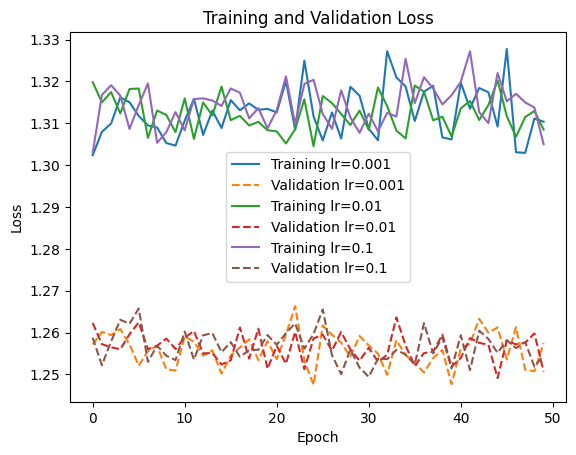

In [ ]:
import matplotlib.pyplot as plt


# Plot both training and validation loss on same graph
plt.figure()
for lr in learning_rates:
    plt.plot(training_loss[lr], label=f"Training lr={lr}")
    plt.plot(validation_loss[lr], label=f"Validation lr={lr}", linestyle='--')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


### Here we are loading the model that we have created in colab

In [5]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/dp/Model0.01.pt'))
model = torch.load(r"C:\Users\sujith kumar\Desktop\Flask deployment\models\bestModelAlpha.pt", map_location=torch.device('cpu'))
def evaluate_test_data(index):
    image, mask = test_data_set[index]
    logits_mask = model(image.to(DEVICE).unsqueeze (0)) #(C, H, W) -> (1, C, H, W)
    print(logits_mask.shape)
    pred_mask_prob = torch.softmax(logits_mask, dim=1)  # (batch_size, num_classes, height, width)
    _, pred_mask = torch.max(pred_mask_prob, dim=1)  # (batch_size, height, width)
    show_image(image, mask, pred_mask)
    rgb_mask, label = mask_to_rgb(pred_mask, label=True)
    # Create an alpha mask where alpha=0 for background pixels and alpha=0.5 for all other pixels
    alpha_mask = np.where(np.all(rgb_mask == (0, 0, 0), axis=-1), 0, 0.9)
    # Create a new RGBA mask combining the RGB mask and alpha mask
    rgba_mask = np.concatenate([rgb_mask, alpha_mask[..., np.newaxis]], axis=-1)
    print(label)
    # Overlay the mask on the image
    plt.imshow(image.permute(1, 2, 0))
    plt.imshow(rgba_mask, alpha=0.5)
    plt.xlabel(label)
    plt.title("Picture with Predicted Mask Applied")
    plt.show()
import random

for index in random.sample(list(range(len(test_data_set))), 3):
    evaluate_test_data(index)

NameError: name 'test_data_set' is not defined

In [28]:
learning_rates = [0.001, 0.01, 0.1]
training_loss = dict()
validation_loss = dict()
best_valid_losses = dict()
for lr in learning_rates:
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    best_valid_loss = 1000
    train_losses = list()
    valid_losses = list()
    for i in range(50):
        train_loss = train_fn(train_loader , model , optimizer)
        valid_loss = eval_fn(val_loader , model )
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        if valid_loss< best_valid_loss :
            torch.save(model.state_dict(), '/content/drive/MyDrive/dp/Model{}.pt'.format(lr))
            print ("SAVED")
            best_valid_loss = valid_loss
        print(f"Epoch : {i+1} train_loss :{train_loss} valid_loss :{valid_loss}")
    training_loss.update({lr:train_losses})
    validation_loss.update({lr:valid_losses})
best_valid_losses.update({lr:best_valid_loss})

100%|██████████| 2/2 [00:02<00:00,  1.29s/it, loss=1.79]


SAVED
Epoch : 1 train_loss :1.815430744489034 valid_loss :1.794100046157837


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.76]


SAVED
Epoch : 2 train_loss :1.7902253945668538 valid_loss :1.7593294978141785


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.7]


SAVED
Epoch : 3 train_loss :1.7490802844365438 valid_loss :1.7036280035972595


100%|██████████| 2/2 [00:03<00:00,  1.91s/it, loss=1.63]


SAVED
Epoch : 4 train_loss :1.693075410525004 valid_loss :1.6344311833381653


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.56]


SAVED
Epoch : 5 train_loss :1.6289664030075073 valid_loss :1.5579317808151245


100%|██████████| 2/2 [00:03<00:00,  1.89s/it, loss=1.51]


SAVED
Epoch : 6 train_loss :1.570966625213623 valid_loss :1.5109227299690247


100%|██████████| 2/2 [00:02<00:00,  1.42s/it, loss=1.47]


SAVED
Epoch : 7 train_loss :1.516710138320923 valid_loss :1.4655715227127075


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.43]


SAVED
Epoch : 8 train_loss :1.477321982383728 valid_loss :1.4254436492919922


100%|██████████| 2/2 [00:02<00:00,  1.39s/it, loss=1.4]


SAVED
Epoch : 9 train_loss :1.4480113744735719 valid_loss :1.3963595032691956


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.37]


SAVED
Epoch : 10 train_loss :1.411223260561625 valid_loss :1.3670665621757507


100%|██████████| 2/2 [00:02<00:00,  1.37s/it, loss=1.36]


SAVED
Epoch : 11 train_loss :1.3867162148157754 valid_loss :1.35584557056427


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.34]


SAVED
Epoch : 12 train_loss :1.3773504416147868 valid_loss :1.3387466073036194


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.33]


SAVED
Epoch : 13 train_loss :1.3624298334121705 valid_loss :1.3310949206352234


100%|██████████| 2/2 [00:02<00:00,  1.47s/it, loss=1.32]


SAVED
Epoch : 14 train_loss :1.3583282709121705 valid_loss :1.3206034898757935


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.3]


SAVED
Epoch : 15 train_loss :1.3546544154485067 valid_loss :1.3029227256774902


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.31]


Epoch : 16 train_loss :1.341770100593567 valid_loss :1.3058013916015625


100%|██████████| 2/2 [00:03<00:00,  1.53s/it, loss=1.3]


SAVED
Epoch : 17 train_loss :1.345061182975769 valid_loss :1.2992839813232422


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.3]


SAVED
Epoch : 18 train_loss :1.3326335827509561 valid_loss :1.2962199449539185


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.3]


SAVED
Epoch : 19 train_loss :1.3401274919509887 valid_loss :1.2958040237426758


100%|██████████| 2/2 [00:03<00:00,  1.52s/it, loss=1.29]


SAVED
Epoch : 20 train_loss :1.3284488757451376 valid_loss :1.290095865726471


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.29]


SAVED
Epoch : 21 train_loss :1.3388304154078166 valid_loss :1.2886600494384766


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.28]


SAVED
Epoch : 22 train_loss :1.3325805028279623 valid_loss :1.2783122658729553


100%|██████████| 2/2 [00:02<00:00,  1.38s/it, loss=1.27]


SAVED
Epoch : 23 train_loss :1.324959127108256 valid_loss :1.272370159626007


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.28]


Epoch : 24 train_loss :1.3242520411809287 valid_loss :1.28170508146286


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.27]


Epoch : 25 train_loss :1.3297452370325724 valid_loss :1.2729063034057617


100%|██████████| 2/2 [00:03<00:00,  1.59s/it, loss=1.28]


Epoch : 26 train_loss :1.327768079439799 valid_loss :1.2781840562820435


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.27]


SAVED
Epoch : 27 train_loss :1.3422824223836263 valid_loss :1.2716071009635925


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.27]


SAVED
Epoch : 28 train_loss :1.3243019421895346 valid_loss :1.2707350254058838


100%|██████████| 2/2 [00:03<00:00,  1.64s/it, loss=1.28]


Epoch : 29 train_loss :1.3229605436325074 valid_loss :1.2761066555976868


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.27]


SAVED
Epoch : 30 train_loss :1.32162766456604 valid_loss :1.2695146203041077


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.27]


SAVED
Epoch : 31 train_loss :1.324052389462789 valid_loss :1.2686424851417542


100%|██████████| 2/2 [00:03<00:00,  1.60s/it, loss=1.27]


SAVED
Epoch : 32 train_loss :1.3350909948349 valid_loss :1.2670616507530212


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.27]


Epoch : 33 train_loss :1.3227405071258544 valid_loss :1.2707412838935852


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.27]


SAVED
Epoch : 34 train_loss :1.3194445053736368 valid_loss :1.265676200389862


100%|██████████| 2/2 [00:03<00:00,  1.58s/it, loss=1.27]


Epoch : 35 train_loss :1.3228201389312744 valid_loss :1.2666127681732178


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.27]


Epoch : 36 train_loss :1.3193890492121378 valid_loss :1.2728039026260376


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.26]


SAVED
Epoch : 37 train_loss :1.3151842912038167 valid_loss :1.2631796598434448


100%|██████████| 2/2 [00:03<00:00,  1.69s/it, loss=1.27]


Epoch : 38 train_loss :1.3185073216756185 valid_loss :1.2672637104988098


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.27]


Epoch : 39 train_loss :1.3268857717514038 valid_loss :1.2714561820030212


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 40 train_loss :1.313593085606893 valid_loss :1.263797640800476


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.27]


Epoch : 41 train_loss :1.3199181318283082 valid_loss :1.267240047454834


100%|██████████| 2/2 [00:03<00:00,  1.65s/it, loss=1.26]


SAVED
Epoch : 42 train_loss :1.3208530346552532 valid_loss :1.2598677277565002


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.26]


Epoch : 43 train_loss :1.318795927365621 valid_loss :1.2637710571289062


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.26]


Epoch : 44 train_loss :1.3235795974731446 valid_loss :1.2630154490470886


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.27]


Epoch : 45 train_loss :1.3103580633799234 valid_loss :1.2680410146713257


100%|██████████| 2/2 [00:03<00:00,  1.65s/it, loss=1.26]


Epoch : 46 train_loss :1.3174525896708171 valid_loss :1.2641913294792175


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.27]


Epoch : 47 train_loss :1.3240744908650717 valid_loss :1.2671907544136047


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.26]


Epoch : 48 train_loss :1.322435704867045 valid_loss :1.2616719603538513


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.26]


Epoch : 49 train_loss :1.313892165819804 valid_loss :1.261361837387085


100%|██████████| 2/2 [00:03<00:00,  1.59s/it, loss=1.27]


Epoch : 50 train_loss :1.3084352254867553 valid_loss :1.2656881213188171


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.26]


SAVED
Epoch : 1 train_loss :1.320943037668864 valid_loss :1.263105869293213


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.27]


Epoch : 2 train_loss :1.3090861797332765 valid_loss :1.2657299041748047


100%|██████████| 2/2 [00:03<00:00,  1.69s/it, loss=1.26]


SAVED
Epoch : 3 train_loss :1.3171279271443685 valid_loss :1.2599811553955078


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.26]


Epoch : 4 train_loss :1.3101391077041626 valid_loss :1.264100730419159


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.26]


SAVED
Epoch : 5 train_loss :1.3114769458770752 valid_loss :1.259311556816101


100%|██████████| 2/2 [00:02<00:00,  1.49s/it, loss=1.25]


SAVED
Epoch : 6 train_loss :1.3130873839060466 valid_loss :1.2510108947753906


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.26]


Epoch : 7 train_loss :1.2983766555786134 valid_loss :1.2619601488113403


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.27]


Epoch : 8 train_loss :1.3068162282307942 valid_loss :1.26925528049469


100%|██████████| 2/2 [00:02<00:00,  1.30s/it, loss=1.27]


Epoch : 9 train_loss :1.2971509615580241 valid_loss :1.2671533226966858


100%|██████████| 2/2 [00:02<00:00,  1.43s/it, loss=1.25]


Epoch : 10 train_loss :1.2963110526402792 valid_loss :1.2540210485458374


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.27]


Epoch : 11 train_loss :1.3005601088205974 valid_loss :1.2657887935638428


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.26]


Epoch : 12 train_loss :1.2979163885116578 valid_loss :1.257670521736145


100%|██████████| 2/2 [00:02<00:00,  1.35s/it, loss=1.26]


Epoch : 13 train_loss :1.295614210764567 valid_loss :1.263171672821045


100%|██████████| 2/2 [00:03<00:00,  1.50s/it, loss=1.25]


Epoch : 14 train_loss :1.3113555987675984 valid_loss :1.2535058856010437


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.26]


Epoch : 15 train_loss :1.2987789074579874 valid_loss :1.259486198425293


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.25]


Epoch : 16 train_loss :1.286883282661438 valid_loss :1.254282832145691


100%|██████████| 2/2 [00:02<00:00,  1.34s/it, loss=1.25]


SAVED
Epoch : 17 train_loss :1.292150322596232 valid_loss :1.250659704208374


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.25]


SAVED
Epoch : 18 train_loss :1.2873727162679036 valid_loss :1.2503051161766052


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.26]


Epoch : 19 train_loss :1.2752168973286946 valid_loss :1.2566632628440857


100%|██████████| 2/2 [00:02<00:00,  1.39s/it, loss=1.25]


Epoch : 20 train_loss :1.2839488108952841 valid_loss :1.2515170574188232


100%|██████████| 2/2 [00:02<00:00,  1.37s/it, loss=1.26]


Epoch : 21 train_loss :1.2803051789601645 valid_loss :1.2597994804382324


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.25]


Epoch : 22 train_loss :1.2771188497543335 valid_loss :1.2505132555961609


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.26]


Epoch : 23 train_loss :1.2817987124125163 valid_loss :1.260066270828247


100%|██████████| 2/2 [00:02<00:00,  1.43s/it, loss=1.26]


Epoch : 24 train_loss :1.2842464049657185 valid_loss :1.2561495900154114


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.26]


Epoch : 25 train_loss :1.2782288392384846 valid_loss :1.2570688724517822


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.25]


SAVED
Epoch : 26 train_loss :1.276856295267741 valid_loss :1.2453182339668274


100%|██████████| 2/2 [00:02<00:00,  1.29s/it, loss=1.25]


Epoch : 27 train_loss :1.2817197640736897 valid_loss :1.2497486472129822


100%|██████████| 2/2 [00:03<00:00,  1.52s/it, loss=1.25]


Epoch : 28 train_loss :1.2833088000615438 valid_loss :1.2494176626205444


100%|██████████| 2/2 [00:02<00:00,  1.15s/it, loss=1.25]


Epoch : 29 train_loss :1.2754953304926555 valid_loss :1.2501775026321411


100%|██████████| 2/2 [00:02<00:00,  1.15s/it, loss=1.25]


Epoch : 30 train_loss :1.2860196749369304 valid_loss :1.245851993560791


100%|██████████| 2/2 [00:02<00:00,  1.29s/it, loss=1.24]


SAVED
Epoch : 31 train_loss :1.2752113421758016 valid_loss :1.2438250184059143


100%|██████████| 2/2 [00:02<00:00,  1.28s/it, loss=1.25]


Epoch : 32 train_loss :1.2730162064234416 valid_loss :1.2472397089004517


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.24]


SAVED
Epoch : 33 train_loss :1.2670281092325846 valid_loss :1.243560791015625


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.24]


SAVED
Epoch : 34 train_loss :1.2697038571039836 valid_loss :1.2419366240501404


100%|██████████| 2/2 [00:02<00:00,  1.36s/it, loss=1.25]


Epoch : 35 train_loss :1.2723093112309773 valid_loss :1.2500590085983276


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.25]


Epoch : 36 train_loss :1.2611589034398396 valid_loss :1.2540758848190308


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.25]


Epoch : 37 train_loss :1.2750784079233806 valid_loss :1.2461007237434387


100%|██████████| 2/2 [00:02<00:00,  1.49s/it, loss=1.25]


Epoch : 38 train_loss :1.2750269095102946 valid_loss :1.2491329908370972


100%|██████████| 2/2 [00:02<00:00,  1.22s/it, loss=1.25]


Epoch : 39 train_loss :1.26909388701121 valid_loss :1.2521337270736694


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.25]


Epoch : 40 train_loss :1.26738707224528 valid_loss :1.2524983882904053


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.24]


Epoch : 41 train_loss :1.2656328837076822 valid_loss :1.2436149716377258


100%|██████████| 2/2 [00:02<00:00,  1.41s/it, loss=1.24]


Epoch : 42 train_loss :1.2586447715759277 valid_loss :1.243380069732666


100%|██████████| 2/2 [00:02<00:00,  1.38s/it, loss=1.24]


SAVED
Epoch : 43 train_loss :1.2632317622502645 valid_loss :1.2403407096862793


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.24]


SAVED
Epoch : 44 train_loss :1.2651739676793416 valid_loss :1.236412227153778


100%|██████████| 2/2 [00:02<00:00,  1.35s/it, loss=1.24]


Epoch : 45 train_loss :1.2669275919596354 valid_loss :1.2438059449195862


100%|██████████| 2/2 [00:02<00:00,  1.40s/it, loss=1.25]


Epoch : 46 train_loss :1.2588514963785806 valid_loss :1.2486056089401245


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.23]


SAVED
Epoch : 47 train_loss :1.2529969215393066 valid_loss :1.234956979751587


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.25]


Epoch : 48 train_loss :1.2575082302093505 valid_loss :1.2486941814422607


100%|██████████| 2/2 [00:03<00:00,  1.57s/it, loss=1.24]


Epoch : 49 train_loss :1.264595667521159 valid_loss :1.2386228442192078


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.24]


Epoch : 50 train_loss :1.2525841156641642 valid_loss :1.235629379749298


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.25]


SAVED
Epoch : 1 train_loss :1.2533459663391113 valid_loss :1.2457488179206848


100%|██████████| 2/2 [00:03<00:00,  1.65s/it, loss=1.42]


Epoch : 2 train_loss :1.254628268877665 valid_loss :1.421696662902832


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.27]


Epoch : 3 train_loss :1.2532907485961915 valid_loss :1.2693820595741272


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.24]


SAVED
Epoch : 4 train_loss :1.2463913758595784 valid_loss :1.2406290173530579


100%|██████████| 2/2 [00:02<00:00,  1.45s/it, loss=1.23]


SAVED
Epoch : 5 train_loss :1.2373590787251791 valid_loss :1.2338008880615234


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.21]


SAVED
Epoch : 6 train_loss :1.2183570941289266 valid_loss :1.212651014328003


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.22]


Epoch : 7 train_loss :1.2101323127746582 valid_loss :1.2208040356636047


100%|██████████| 2/2 [00:03<00:00,  1.59s/it, loss=1.21]


Epoch : 8 train_loss :1.2217632293701173 valid_loss :1.214510440826416


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.2]


SAVED
Epoch : 9 train_loss :1.22366308371226 valid_loss :1.2033599615097046


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.25]


Epoch : 10 train_loss :1.2223100821177164 valid_loss :1.2510343790054321


100%|██████████| 2/2 [00:02<00:00,  1.38s/it, loss=1.21]


Epoch : 11 train_loss :1.210737649599711 valid_loss :1.210180401802063


100%|██████████| 2/2 [00:02<00:00,  1.38s/it, loss=1.2]


SAVED
Epoch : 12 train_loss :1.2041170438130697 valid_loss :1.1992243528366089


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.2]


Epoch : 13 train_loss :1.1983408292134603 valid_loss :1.2045065760612488


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.2]


SAVED
Epoch : 14 train_loss :1.1861263116200764 valid_loss :1.197031855583191


100%|██████████| 2/2 [00:02<00:00,  1.41s/it, loss=1.2]


SAVED
Epoch : 15 train_loss :1.1880487521489462 valid_loss :1.1962085962295532


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.19]


SAVED
Epoch : 16 train_loss :1.187321956952413 valid_loss :1.1880003213882446


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.19]


Epoch : 17 train_loss :1.1867639780044557 valid_loss :1.1909666061401367


100%|██████████| 2/2 [00:03<00:00,  1.55s/it, loss=1.19]


SAVED
Epoch : 18 train_loss :1.1865601698557535 valid_loss :1.186341106891632


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.18]


SAVED
Epoch : 19 train_loss :1.1797337611516316 valid_loss :1.1831637024879456


100%|██████████| 2/2 [00:02<00:00,  1.15s/it, loss=1.18]


SAVED
Epoch : 20 train_loss :1.1811362822850546 valid_loss :1.1764686703681946


100%|██████████| 2/2 [00:03<00:00,  1.66s/it, loss=1.16]


SAVED
Epoch : 21 train_loss :1.1709844986597697 valid_loss :1.1569570302963257


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.15]


SAVED
Epoch : 22 train_loss :1.1635533332824708 valid_loss :1.1533814668655396


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.14]


SAVED
Epoch : 23 train_loss :1.1573904434839883 valid_loss :1.1367531418800354


100%|██████████| 2/2 [00:02<00:00,  1.28s/it, loss=1.15]


Epoch : 24 train_loss :1.1565943479537963 valid_loss :1.145786464214325


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.14]


Epoch : 25 train_loss :1.1400252978007 valid_loss :1.1418790817260742


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.15]


Epoch : 26 train_loss :1.1389870484670004 valid_loss :1.1487202048301697


100%|██████████| 2/2 [00:03<00:00,  1.65s/it, loss=1.14]


SAVED
Epoch : 27 train_loss :1.1266886552174886 valid_loss :1.135467290878296


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.14]


Epoch : 28 train_loss :1.1367514928181965 valid_loss :1.137600839138031


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.14]


SAVED
Epoch : 29 train_loss :1.1405219078063964 valid_loss :1.1353859901428223


100%|██████████| 2/2 [00:03<00:00,  1.64s/it, loss=1.15]


Epoch : 30 train_loss :1.1309849739074707 valid_loss :1.146217942237854


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.14]


SAVED
Epoch : 31 train_loss :1.1256149530410766 valid_loss :1.1351760029792786


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.14]


Epoch : 32 train_loss :1.1228728532791137 valid_loss :1.1392279267311096


100%|██████████| 2/2 [00:03<00:00,  1.52s/it, loss=1.14]


Epoch : 33 train_loss :1.131916077931722 valid_loss :1.1391157507896423


100%|██████████| 2/2 [00:02<00:00,  1.27s/it, loss=1.13]


SAVED
Epoch : 34 train_loss :1.1206745147705077 valid_loss :1.1342178583145142


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.13]


SAVED
Epoch : 35 train_loss :1.118227728207906 valid_loss :1.1254672408103943


100%|██████████| 2/2 [00:02<00:00,  1.41s/it, loss=1.13]


Epoch : 36 train_loss :1.117349131902059 valid_loss :1.1256949305534363


100%|██████████| 2/2 [00:02<00:00,  1.35s/it, loss=1.12]


SAVED
Epoch : 37 train_loss :1.1300727605819703 valid_loss :1.1233147382736206


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.13]


Epoch : 38 train_loss :1.120375363032023 valid_loss :1.1291313767433167


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.13]


Epoch : 39 train_loss :1.1221211036046346 valid_loss :1.1259614825248718


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=1.12]


SAVED
Epoch : 40 train_loss :1.1215509176254272 valid_loss :1.1225987672805786


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=1.13]


Epoch : 41 train_loss :1.1167467037836711 valid_loss :1.1264102458953857


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.13]


Epoch : 42 train_loss :1.1188095410664876 valid_loss :1.127695918083191


100%|██████████| 2/2 [00:03<00:00,  1.64s/it, loss=1.13]


Epoch : 43 train_loss :1.124794594446818 valid_loss :1.1266494989395142


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.13]


Epoch : 44 train_loss :1.1184656381607057 valid_loss :1.1317662000656128


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.12]


Epoch : 45 train_loss :1.1127826849619546 valid_loss :1.1232088208198547


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=1.13]


Epoch : 46 train_loss :1.1174527565638224 valid_loss :1.1262354850769043


100%|██████████| 2/2 [00:03<00:00,  1.65s/it, loss=1.13]


Epoch : 47 train_loss :1.1166006485621134 valid_loss :1.1314790844917297


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.14]


Epoch : 48 train_loss :1.1168620665868123 valid_loss :1.1420625448226929


100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=1.14]


Epoch : 49 train_loss :1.1172374963760376 valid_loss :1.1373232007026672


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=1.14]

Epoch : 50 train_loss :1.1233824332555136 valid_loss :1.1408249139785767


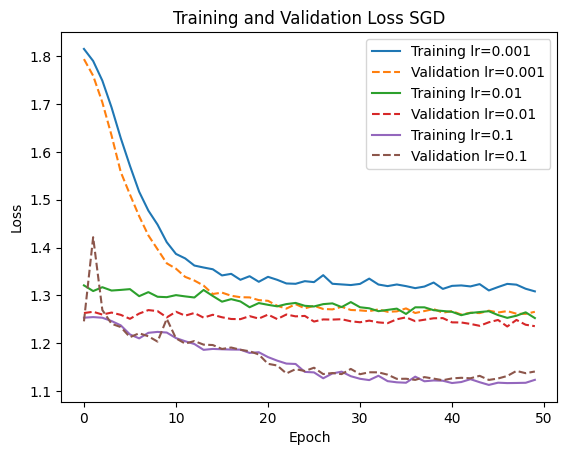

In [29]:
import matplotlib.pyplot as plt


# Plot both training and validation loss on same graph
plt.figure()
for lr in learning_rates:
    plt.plot(training_loss[lr], label=f"Training lr={lr}")
    plt.plot(validation_loss[lr], label=f"Validation lr={lr}", linestyle='--')
plt.title("Training and Validation Loss SGD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
model.load_state_dict(torch.load('/content/drive/MyDrive/dp/Model0.1.pt'))

<All keys matched successfully>

# Task 11: Evaluation on Test data Using best Model so far

In [35]:
def evaluate_test_data(index):
    image, mask = test_data_set[index]
    logits_mask = model(image.to(DEVICE).unsqueeze (0)) #(C, H, W) -> (1, C, H, W)
    print(logits_mask.shape)
    pred_mask_prob = torch.softmax(logits_mask, dim=1)  # (batch_size, num_classes, height, width)
    _, pred_mask = torch.max(pred_mask_prob, dim=1)  # (batch_size, height, width)
    show_image(image, mask, pred_mask)
    rgb_mask, label = mask_to_rgb(pred_mask, label=True)
    # Create an alpha mask where alpha=0 for background pixels and alpha=0.5 for all other pixels
    alpha_mask = np.where(np.all(rgb_mask == (0, 0, 0), axis=-1), 0, 0.9)
    # Create a new RGBA mask combining the RGB mask and alpha mask
    rgba_mask = np.concatenate([rgb_mask, alpha_mask[..., np.newaxis]], axis=-1)
    print(label)
    # Overlay the mask on the image
    plt.imshow(image.permute(1, 2, 0))
    plt.imshow(rgba_mask, alpha=0.5)
    plt.xlabel(label)
    plt.title("Picture with Predicted Mask Applied")
    plt.show()

torch.Size([1, 6, 320, 320])


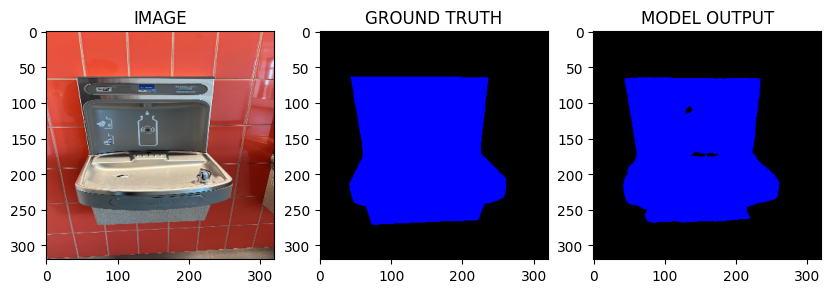

Water Dispenser


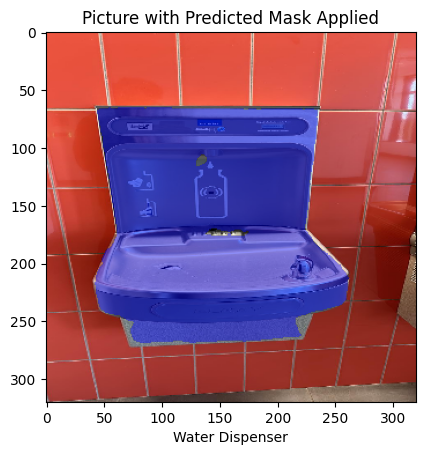

torch.Size([1, 6, 320, 320])


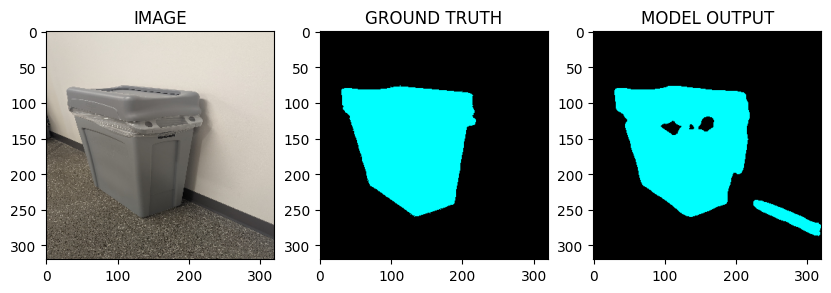

Trash bin


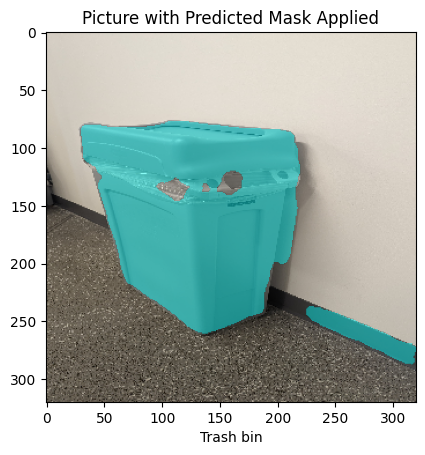

torch.Size([1, 6, 320, 320])


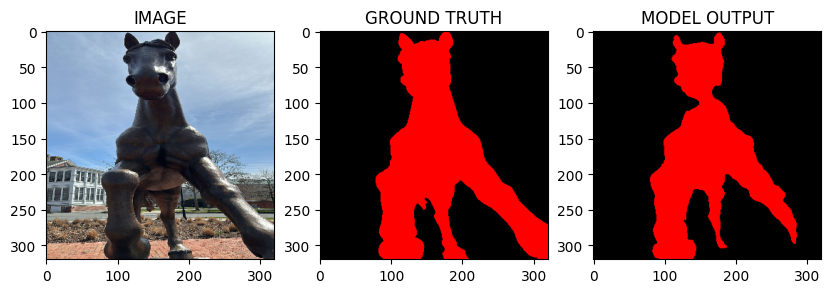

Horse


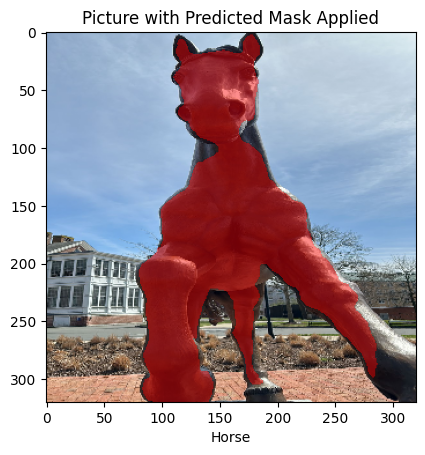

In [31]:
import random

for index in random.sample(list(range(len(test_data_set))), 3):
    evaluate_test_data(index)

<p><b>Intersection over Union (IoU)</b>: This is a widely used metric to evaluate the performance of a segmentation model. It measures the overlap between the predicted segmentation and the ground truth segmentation. IoU is defined as the area of intersection divided by the area of union between the predicted and ground truth segmentations. </p>

In [15]:
def normalize_list(lst):
    min_val = min(lst)
    max_val = max(lst)
    range_val = max_val - min_val
    normalized_lst = [(x - min_val) / range_val for x in lst]
    return normalized_lst

In [16]:
def calculate_iou(pred_masks, true_masks):
    iou_scores = []
    for i in range(len(pred_masks)):
        pred_mask = pred_masks[i].flatten()  # flatten the mask
        true_mask = true_masks[i].flatten()  # flatten the mask
        intersection = np.sum(pred_mask * true_mask)
        union = np.sum((pred_mask + true_mask) > 0)
        iou = intersection / union
        iou_scores.append(iou)
    normalized_iou_score = normalize_list(iou_scores)
    mean_iou = np.mean(normalized_iou_score)
    return mean_iou

In [17]:
pred_masks = []
true_masks = []
for i in range(len(test_data_set)):
    image, mask = test_data_set[i]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
    print(logits_mask.shape)
    pred_mask_prob = torch.softmax(logits_mask, dim=1)  # (batch_size, num_classes, height, width)
    _, pred_mask = torch.max(pred_mask_prob, dim=1)  # (batch_size, height, width)
    
    pred_mask = pred_mask.detach().cpu().numpy()
    true_mask = mask.numpy()
    pred_masks.append(pred_mask)
    true_masks.append(true_mask)
mean_iou = calculate_iou(pred_masks, true_masks)

NameError: name 'test_data_set' is not defined

In [ ]:
print('Mean Intersection over Unioin score is: {}'.format(mean_iou))

Mean Intersection over Unioin score is: 0.3887113452059166


In [1]:
!pip list

Package                            Version
---------------------------------- -----------------
absl-py                            0.12.0
aiohttp                            3.8.4
aiosignal                          1.3.1
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
asgiref                            3.3.4
asn1crypto                         1.4.0
astor                              0.8.1
astroid                            2.4.2
astropy                            4.0.2
asttokens                          2.0.5
astunparse                         1.6.3
async-generator                    1.10
async-timeout                      4.0.2
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



lxml                               4.6.1
Markdown                           3.3.4
MarkupSafe                         1.1.1
matplotlib                         3.3.2
matplotlib-inline                  0.1.3
mccabe                             0.6.1
menuinst                           1.4.16
mistune                            0.8.4
mkl-fft                            1.2.0
mkl-random                         1.1.1
mkl-service                        2.3.0
mlens                              0.2.3
mock                               4.0.2
more-itertools                     8.6.0
mpmath                             1.1.0
msgpack                            1.0.0
multidict                          6.0.4
multipledispatch                   0.6.0
multiprocess                       0.70.14
munch                              2.5.0
murmurhash                         1.0.9
mypy-extensions                    0.4.3
navigator-updater                  0.2.1
nbclient                           0.5.1
nbconvert   

# In general the IOU score lies in between 0 to 1 higher the score better the performance